<div style="float:left">
    <h1 style="width:450px">Practical 8: </h1>
    <h2 style="width:450px">Visualisation and Linked Data</h2>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

<div style="border: dotted 1px rgb(156,121,26); padding: 10px; margin: 5px; background-color: rgb(255,236,184)"><i>Note</i>: You should download this notebook from GitHub and then save it to your own copy of the repository. I'd suggest adding it (<tt>git add Practial-...</tt>) right away and then committing (<tt>git commit -m "Some message"</tt>). Do this again at the end of the class and you'll have a record of everything you did, then you can <tt>git push</tt> it to GitHub.</div>

In [11]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.cm as cm
import matplotlib.pyplot as plt

## Task 1. Find London MSOAs

#### Grab E+W MSOA Shapefile

This -- and a lot of other data besides! -- can be accessed from the [GeoPortal](https://geoportal.statistics.gov.uk/datasets/middle-layer-super-output-areas-december-2011-ew-bgc-v2). And see also my discussion on [lookup tables](https://geoportal.statistics.gov.uk/datasets/postcode-to-output-area-to-lower-layer-super-output-area-to-middle-layer-super-output-area-to-local-authority-district-december-2011-lookup-in-england-and-wales).

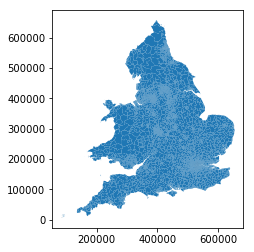

In [12]:
msoas = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip?raw=true')
msoas.plot()

In [13]:
msoas.sample(3)

,OBJECTID,MSOA11CD,MSOA11NM,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry
970,971,E02001003,Bolton 020,Bolton 020,368340,408596,-2.47957,53.57302,3.926261e+06,12268.977129,"POLYGON ((367397.509 409596.202, 367502.571 40..."
2097,2098,E02002156,Wolverhampton 008,Wolverhampton 008,393595,301264,-2.09601,52.60913,1.562030e+06,7269.126016,"POLYGON ((393594.989 301992.437, 393670.021 30..."
3418,3419,E02003508,Brighton and Hove 018,Brighton and Hove 018,532595,105908,-0.11826,50.83751,8.602909e+05,8455.042587,"POLYGON ((532585.316 106129.673, 532661.053 10..."


#### Grab the Borough Boundaries

In [14]:
boros = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true')

We can then generate the boundary for London using the `unary_union` operator (as we do here) or using the earlier [`dissolve(by=region)`](https://geopandas.org/aggregation_with_dissolve.html) approach. Consider the pros and cons of each approach in terms of performance, output format, and legibility. 

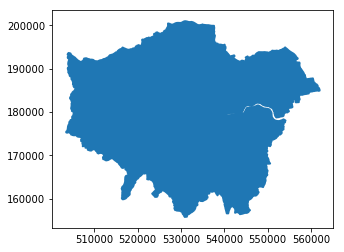

In [15]:
ldn = gpd.GeoDataFrame(gpd.GeoSeries(data=boros.unary_union, crs='epsg:27700')).rename(columns={0:'original'})

# In order to ensure that we get all MSOAs _within_ London 
# we will buffer the boundary by 250m. If _cover_ were 
# easier to use then that option might be preferable.
ldn['geometry'] = ldn.original.buffer(250)
ldn = ldn.set_geometry('geometry')
ldn.plot();

#### Task 1.1: Select London MSOAs using a Spatial Join

Here's our first spatial join. By default it will be an _inner_ join.

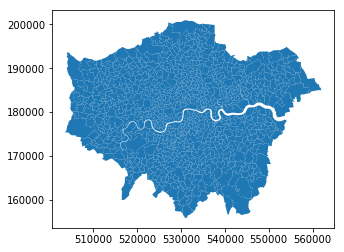

In [16]:
ldn_msoas = gpd.sjoin(msoas, ldn, op='within')  # so this is keeping only left fields
ldn_msoas.plot();

We no longer really need to keep the full MSOA data set hanging about.

In [17]:
del(msoas)

In [20]:
ldn_msoas.MSOA11CD.head(10)

0    E02000001
1    E02000002
2    E02000003
3    E02000004
4    E02000005
5    E02000007
6    E02000008
7    E02000009
8    E02000010
9    E02000011
Name: MSOA11CD, dtype: object

#### Task 1.2: Extract Borough Names

Notice that the MSOA Name _contains_ the Borough name. Use a regex (in `str.replace()`) to extract the LA name from the MSOA name.

In [19]:
ldn_msoas['Borough'] = ldn_msoas.MSOA11NM.str.replace(r'\s\d{3}$','',regex=True)
#removing the numbers 
# Just check results look plausible; you should have:
# - 33 boroughs
# - A df shape of 983 x 14
print(ldn_msoas.Borough.unique())
print(len(ldn_msoas.Borough.unique()))
print(ldn_msoas.shape)

['City of London' 'Barking and Dagenham' 'Barnet' 'Bexley' 'Brent'
 'Bromley' 'Camden' 'Croydon' 'Ealing' 'Enfield' 'Greenwich' 'Hackney'
 'Hammersmith and Fulham' 'Haringey' 'Harrow' 'Havering' 'Hillingdon'
 'Hounslow' 'Islington' 'Kensington and Chelsea' 'Kingston upon Thames'
 'Lambeth' 'Lewisham' 'Merton' 'Newham' 'Redbridge' 'Richmond upon Thames'
 'Southwark' 'Sutton' 'Tower Hamlets' 'Waltham Forest' 'Wandsworth'
 'Westminster']
33
(983, 14)


#### Task 1.3: Add MSOA Names using a Merge

The House of Commons Library provides a [MSOA Names](https://visual.parliament.uk/msoanames) data set that contains locally-relevant names applied to MSOAs. These seek to connect the Census geography (OA > LSOA > MSOA > LA) to a loosely-defined 'neighbourhood'.

In [21]:
msoa_nms = pd.read_csv('https://github.com/jreades/i2p/blob/master/data/src/MSOA-Names-1.8.csv.gz?raw=true', compression='gzip')

In [22]:
print(msoa_nms.columns.values)
msoa_nms.sample(3, random_state=42)

['msoa11cd' 'msoa11nm' 'msoa11nmw' 'msoa11hclnm' 'msoa11hclnmw' 'Laname']


,msoa11cd,msoa11nm,msoa11nmw,msoa11hclnm,msoa11hclnmw,Laname
4512,E02005951,Oxford 012,Oxford 012,Grandpont & New Hinksey,NaN,Oxford
4660,W02000113,Powys 017,Powys 017,Brecon,Aberhonddu,Powys
1038,W02000309,Caerphilly 020,Caerffili 020,Bedwas & Trethomas,Bedwas a Thretomas,Caerphilly


In [23]:
print(ldn_msoas.columns.values)

['OBJECTID' 'MSOA11CD' 'MSOA11NM' 'MSOA11NMW' 'BNG_E' 'BNG_N' 'LONG' 'LAT'
 'Shape__Are' 'Shape__Len' 'geometry' 'index_right' 'original' 'Borough']


Now that you've loaded the `msoa_nms` data you need to merge it with our `ldn_msoas`. You will need to deal with the fact that the left and right fields have different names and may also want to think about the `how` of the merge.

In [25]:
msoas = pd.merge(ldn_msoas, msoa_nms, left_on = "MSOA11CD", right_on = "msoa11cd", how="inner")
print(msoas.shape)
print(type(msoas)) # You should check this -- result isn't always be a GeoDataFrame
msoas.sample(3, random_state=42)[['OBJECTID','MSOA11CD','MSOA11NM','msoa11hclnm']]

(983, 20)
<class 'geopandas.geodataframe.GeoDataFrame'>


,OBJECTID,MSOA11CD,MSOA11NM,msoa11hclnm
810,811,E02000841,Sutton 002,St Helier South
801,802,E02000832,Southwark 026,Nunhead North
813,814,E02000844,Sutton 005,The Wrythe


Your result should be:

|    | OBJECTID | MSOA11CD | MSOA11NM | msoa11hclnm |
| -: | -------: | -------: | :------- | :---------- |
| **810** | 811 | E02000841 | Sutton 002 | St Helier South |
| **801** | 802 | E02000832 | Southwark 026 | Nunhead North |
| **813** | 814 | E02000844 | Sutton 005 | The Wrythe |

#### Tidy Up

In [26]:
to_drop = ['MSOA11NMW','LONG','LAT','Shape__Are','Shape__Len','index_right',
           'original','msoa11cd','msoa11nm','msoa11nmw','Laname','msoa11hclnmw']
msoas.drop(columns=to_drop, inplace=True)
print(msoas.shape)

(983, 8)


#### And Save

In [27]:
pwd

'/Users/sophieayling/Documents/GitHub/i2p/practicals'

In [30]:
msoas.to_file(os.path.join('../','data','geo','London_MSOAs.gpkg'), driver='GPKG')
# it will automatically replace the dataset unless you create a function to check the file already exists 
# you can create a function that asks yes

## Task 2. Load InsideAirbnb Data

Load the InsideAirbnb data into a DataFrame.

In [33]:
cols = ['id','name','price','latitude','longitude','property_type','room_type']
df = pd.read_csv("../data/raw/2020-08-24-listings.csv.gz", usecols=cols, low_memory=False)

Clean the data:

In [34]:
df['price'] = df.price.str.replace('$','').str.replace(',','').astype(float) 
# you can do this as a regex as shown above, that is better
df.drop(df[((df.latitude.isna())|(df.longitude.isna()))].index, axis=0, inplace=True)
#dropping latitudes and long that are missing
df.drop(df[((df.latitude < 40)|(df.longitude > 1))].index, axis=0, inplace=True)
#dropping lat and long that are outside the boundary
print(df.shape)

(74184, 7)


#### Task 2.1: Add Geometry and Reproject

Convert the df into a GeoDataFrame named gdf:

In [37]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude,crs='epsg:4326'))
# importing the data using gpd.points_from_xy
gdf = gdf.to_crs('epsg:27700')  # changing the crs
gdf.head()

,id,name,latitude,longitude,property_type,room_type,price,geometry
0,11551.0,Arty and Bright London Apartment in Zone 2,51.46225,-0.11732,Entire apartment,Entire home/apt,87.0,POINT (530885.122 175377.940)
1,13913.0,Holiday London DB Room Let-on going,51.56802,-0.11121,Private room in apartment,Private room,49.0,POINT (531005.968 187150.843)
2,15400.0,Bright Chelsea Apartment. Chelsea!,51.48796,-0.16898,Entire apartment,Entire home/apt,75.0,POINT (527225.119 178145.995)
3,17402.0,Superb 3-Bed/2 Bath & Wifi: Trendy W1,51.52195,-0.14094,Entire apartment,Entire home/apt,208.0,POINT (529075.790 181974.865)
4,17506.0,Boutique Chelsea/Fulham Double bed 5-star ensuite,51.47935,-0.19743,Private room in bed and breakfast,Private room,150.0,POINT (525273.544 177139.513)


#### Task 2.2: Add LA Names to Data

Associate LA (Local Authority) names to the listings using a spatial join:

In [38]:
gdf_la = gpd.sjoin(gdf, boros, how="left", op="within")
# keeping the boroughs where there are airbnb data that is kept 
print(gdf_la.columns.values)

['id' 'name' 'latitude' 'longitude' 'property_type' 'room_type' 'price'
 'geometry' 'index_right' 'NAME' 'GSS_CODE' 'HECTARES' 'NONLD_AREA'
 'ONS_INNER']


In [40]:
print(gdf_la.shape)
gdf_la.sample(3, random_state=42)[['id','name','NAME']]

(74184, 14)


,id,name,NAME
66121,41808059.0,"Haverstock Hotel, Twin Room",Camden
58701,38685213.0,Charming 1st floor two bedroom Fulham apartment,Hammersmith and Fulham
53195,35724891.0,Lovely East End En-Suite Room in Great Location.,Tower Hamlets


You should have a GeoDataFrame with 74,184 rows and 15 columns and the following tabular output:

|       | id | name | NAME |
| ----: | -------: | :---------- | :---------- |
| 66121 | 41808059 | Haverstock Hotel, Twin Room | Camden |
| 58701 | 38685213 | Charming 1st floor two bedroom Fulham apartment| Hammersmith and Fulham |
| 53195 | 35724891 | Lovely East End En-Suite Room in Great Location. | Tower Hamlets |

#### Task 2.3: Tidy Up

In [41]:
gdf_la.drop(columns=['index_right','HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)
gdf_la.NAME.unique()

array(['Lambeth', 'Islington', 'Kensington and Chelsea', 'Westminster',
       'Hammersmith and Fulham', 'Barnet', 'Hounslow',
       'Richmond upon Thames', 'Haringey', 'Hackney', 'Southwark',
       'Croydon', 'Tower Hamlets', 'Waltham Forest', 'Brent', 'Camden',
       'Newham', 'Redbridge', 'Merton', 'Lewisham', 'Wandsworth',
       'Bromley', 'Havering', 'Greenwich', 'Ealing', 'Enfield',
       'City of London', 'Barking and Dagenham', 'Hillingdon', 'Harrow',
       'Kingston upon Thames', 'Bexley', 'Sutton', nan], dtype=object)

There's something strange about the output of `unique()` above... can you spot it? There are 15 problematic records... see if you can print them out here:

In [43]:
gdf_la[gdf_la.NAME.isna()][['id','name']]
#  this has calculated some of the locations appearing on the river and outside the boundaries

,id,name
24473,18841368.0,"Luxury Double Room, King Size Bed near to 02 A..."
38487,26648789.0,London Riverview Flat - Excel and City Airport
70689,43596360.0,Modern river view apartment near the centre
70824,43685598.0,Thames view apartment in Battersea
70891,43724271.0,Close to the river - a private space
70954,43755065.0,Cosy friendly house set in a peaceful environm...
71192,43885927.0,Rochester Way Apartment 5
71216,43894894.0,Greenwich Home with a View
72172,44211247.0,Luxury room in shared 2 bed waterfront apartment
72350,44273549.0,Exclusive Bright Studio - Central London


#### Task 2.4: Map Problematic Listings

Now see if you can map them as below:

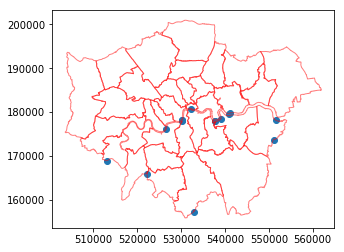

In [51]:
ax = gdf_la[gdf_la.NAME.isna()].plot()
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5)

Your result should be:

![](https://github.com/jreades/i2p/blob/master/lectures/img/Unmatched_Listings.png?raw=true)

#### Task 2.5: Drop Problematic Results

In [52]:
gdf_la.drop(index=gdf_la[gdf_la.NAME.isna(), axis=1, inplace=True)
print(gdf_la.shape)

SyntaxError: invalid syntax (<ipython-input-52-e2138e943678>, line 1)

You should now have 74,169 records.

#### Task 2.6: Check Results

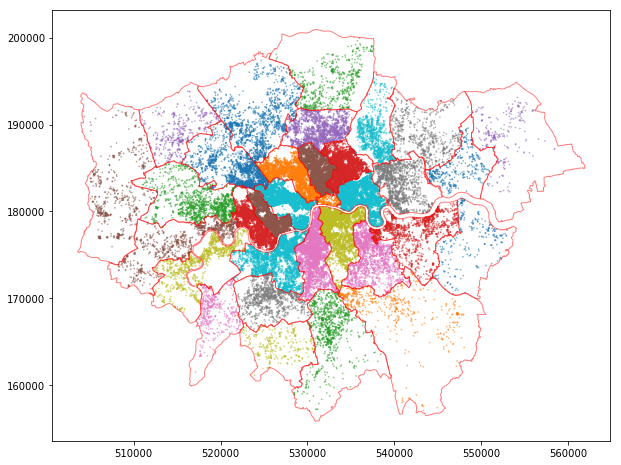

In [46]:
ax = gdf_la.plot(column='NAME', markersize=0.5, alpha=0.5, figsize=(10,8))
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5);

## Task 3. Using Seaborn and Grouped Data

#### Task 3.1: A Basic Boxplot

See if you can create a basic boxplot of price by room type, and then set the y-limits to 0-500 (£/night).

(0, 500)

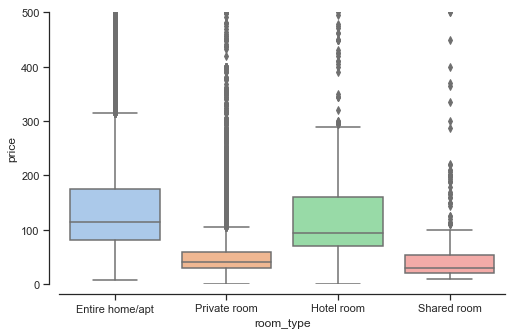

In [53]:
sns.set_style('whitegrid')
sns.set_theme(style="ticks", palette="pastel")
f,ax = plt.subplots(figsize=(8,5))
ax=sns.boxplot(y=gdf_la.price,x=gdf_la.room_type)
sns.despine(offset=10)
ax.set_ylim([0,500])

#### Task 3.2: Grouping on One Column

Let's group the data on the LA name. You should get that the type is a `DataFrameGroupBy`.

In [54]:
la_data = gdf_la.groupby("NAME")
print(type(la_data))

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>


Notice the result here:

In [55]:
la_data.price.mean()

NAME
Barking and Dagenham       59.246719
Barnet                     89.803606
Bexley                     65.969697
Brent                     100.320199
Bromley                    71.495409
Camden                    134.644442
City of London            209.521220
Croydon                    58.140643
Ealing                    100.247022
Enfield                    76.418049
Greenwich                  99.666963
Hackney                    89.672230
Hammersmith and Fulham    130.214894
Haringey                   92.239021
Harrow                     79.084567
Havering                   67.882591
Hillingdon                 60.451494
Hounslow                   97.180144
Islington                 120.629270
Kensington and Chelsea    191.254569
Kingston upon Thames       85.334470
Lambeth                    94.889265
Lewisham                   82.352265
Merton                    111.460489
Newham                     83.756255
Redbridge                  80.051494
Richmond upon Thames      125.371

#### Task 3.3: A Basic Distribution Plot

Although this is hardly the most robust analysis (subtracting the mean of a grouped mean from a grouped mean seems... sketchy), it's useful for quickly demonstrating a different plot type and then asking you to work out how to obtain something close to the output below using these solutions:

- [Figure title](https://matplotlib.org/3.3.3/gallery/subplots_axes_and_figures/figure_title.html)
- [How to position `suptitle`](https://stackoverflow.com/questions/55767312/how-to-position-suptitle)
- [Label axes on Seaborn Barplot](https://stackoverflow.com/questions/31632637/label-axes-on-seaborn-barplot)

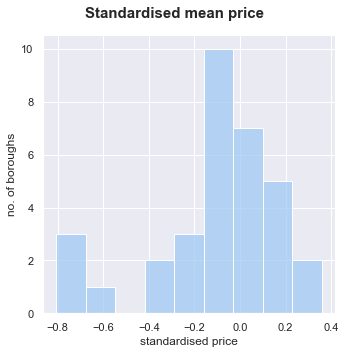

In [58]:
sns.set_style('darkgrid')
ax = sns.displot((la_data.price.mean() - la_data.price.mean().mean())/la_data.price.std())
plt.suptitle("Standardised mean price", fontsize=15, fontweight="bold")
plt.subplots_adjust(top=0.9)
ax.set(xlabel="standardised price", ylabel="no. of boroughs")


In [59]:
la_data.head()

,id,name,latitude,longitude,property_type,room_type,price,geometry,NAME,GSS_CODE
0,11551.0,Arty and Bright London Apartment in Zone 2,51.46225,-0.11732,Entire apartment,Entire home/apt,87.0,POINT (530885.122 175377.940),Lambeth,E09000022
1,13913.0,Holiday London DB Room Let-on going,51.56802,-0.11121,Private room in apartment,Private room,49.0,POINT (531005.968 187150.843),Islington,E09000019
2,15400.0,Bright Chelsea Apartment. Chelsea!,51.48796,-0.16898,Entire apartment,Entire home/apt,75.0,POINT (527225.119 178145.995),Kensington and Chelsea,E09000020
3,17402.0,Superb 3-Bed/2 Bath & Wifi: Trendy W1,51.52195,-0.14094,Entire apartment,Entire home/apt,208.0,POINT (529075.790 181974.865),Westminster,E09000033
4,17506.0,Boutique Chelsea/Fulham Double bed 5-star ensuite,51.47935,-0.19743,Private room in bed and breakfast,Private room,150.0,POINT (525273.544 177139.513),Hammersmith and Fulham,E09000013
...,...,...,...,...,...,...,...,...,...,...
24473,18841368.0,"Luxury Double Room, King Size Bed near to 02 A...",51.48847,0.00160,Private room in apartment,Private room,160.0,POINT (539065.978 178512.702),NaN,NaN
38487,26648789.0,London Riverview Flat - Excel and City Airport,51.49812,0.03001,Entire apartment,Entire home/apt,99.0,POINT (541008.516 179640.102),NaN,NaN
70689,43596360.0,Modern river view apartment near the centre,51.48653,-0.12625,Entire apartment,Entire home/apt,109.0,POINT (530195.718 178062.036),NaN,NaN
70824,43685598.0,Thames view apartment in Battersea,51.47072,-0.17843,Entire apartment,Entire home/apt,80.0,POINT (526616.747 176212.478),NaN,NaN


Your result should be close to:

![](https://github.com/jreades/i2p/blob/master/lectures/img/std_boro_price.png?raw=true)

#### Task 3.4: Grouping on Multiple Columns

We're now going to create a data frame grouped by LA and room type, and then use the `agg` (aggregate) function on a grouped data frame and derive several measures (Count, Sum, Mean, Median, std, Lower Quartile, and Upper Quartile) in one go from the price column. 

You will want to search on something like "Multiple aggregations of the same column using pandas GroupBy.agg()" in order to work this out. 

You'll also need to look at "calculate quantile pandas aggregate" -- depending on the solution you choose, your quantiles may or may not have the same labels as mine below.

In [72]:
la_data2 = gdf_la.groupby(["NAME", "room_type"]).agg({"price": ['count', 'sum', 'mean', 'median', 'std',
                                                             lambda x:x.quantile(0.25), lambda x:x.quantile(0.75)]}).reset_index()

# you can also do the np.sum, np.medium. you are calling lambda as a temporary function, it means you don't have to define a variable first 

In [73]:
la_data2.sample(3, random_state=42)

NAME        room_type price                                           \
                               count       sum        mean median         std   
18    Bromley     Private room   334  17288.86   51.763054   36.0   91.390795   
42  Greenwich     Private room   830  62005.70   74.705663   38.0  223.600981   
36    Enfield  Entire home/apt   217  26437.72  121.832811   95.0  121.763967   

                          
   <lambda_0> <lambda_1>  
18       27.0      50.00  
42       28.0      53.75  
36       70.0     130.00

My sample gives me:

|    | NAME | room_type |     |     |     |     |     |     | price |
| -: | :--- | :-------- | --: | --: | --: | --: | --: | --: | ----: |
|    |      |           | **count** | **sum** | **mean** | **median** | **std** | **\<lambda_0\>** | **\<lambda_1\>** |
| 18 | Bromley | Private room | 334 | 17288.86 | 51.763054 | 36.0 | 91.390795 | 27.0 | 50.00 |
| 42 | Greenwich | Private room | 830 | 62005.70 | 74.705663 | 38.0 | 223.600981 | 28.0 | 53.75 |
| 36 | Enfield | Entire home/apt | 217 | 26437.72 | 121.832811 | 95.0 | 121.763967 | 70.0 | 130.00 |

I am _not_ cruel enough to make you work out how to convert the above to a flat index, so here's the code to do that:

In [74]:
la_data2.columns = la_data2.columns.droplevel(0)
print(la_data2.columns.values)

['' '' 'count' 'sum' 'mean' 'median' 'std' '<lambda_0>' '<lambda_1>']


So now we just need to correct a few column labels manually:

In [75]:
cols = la_data2.columns.values
cols[ 0] = 'name'
cols[ 1] = 'room_type'
cols[-2] = 'lq'
cols[-1] = 'uq'
la_data2.columns = cols

This next plot may take a while to run:

Text(0,0.5,'room type')

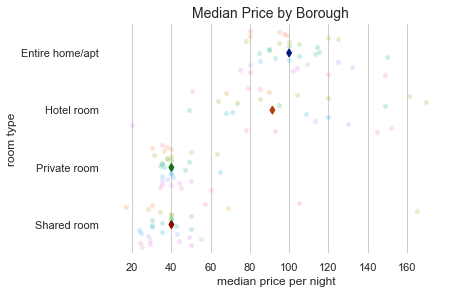

In [76]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
# https://seaborn.pydata.org/examples/jitter_stripplot.html
g = sns.stripplot(x="median", y="room_type", hue="name",
              data=la_data2, dodge=True, alpha=.25, zorder=1)
g.legend_.remove()

# Show the median of medians
sns.pointplot(x="median", y="room_type",
              data=la_data2.groupby('room_type').agg('median').reset_index(), 
              dodge=.232, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

plt.gcf().subplots_adjust(top=0.92)
f.suptitle('Median Price by Borough', fontsize=14);

plt.xlabel("median price per night")
plt.ylabel("room type")

#### Task 3.5: Grouping on a Custom Mapping

Use the map below, taken from the Centre for London's [_Housing and Inequality in London_](https://www.centreforlondon.org/wp-content/uploads/2016/08/CFLJ4292-London-Inequality-04_16_WEB_V4.pdf) (p.17) to assign each LA to one of the five regions shown. Create a grouped data frame using this mapping instead of the LA one. Do so _without_ creating a new column.

![](https://github.com/jreades/i2p/blob/master/lectures/img/Borough_Mapping.png?raw=true)

Set up a `mapping` dict here so that you can apply it as part of the `groupby` operation below (you should have 33 keys when done):

In [70]:
mapping = {}
mapping['Camden']= 'inner west'

# best to do this using a forloop
Inner_west = ["Camden", "City of Westminster", "Kensington", "Haringey", ]
for i in Inner_west:
    mapping[i] = "Inner West"


print(len(mapping.keys()))

3


Group by your mapping and by `room_type`, and calculate the mean and median price only:

In [ ]:
la_data3 = gdf_la.set_index('NAME').groupby([mapping,'room_type']).agg(
    {'price':['mean','median']}
).reset_index()

In [ ]:
la_data3.sample(3, random_state=42)

My output looks like this:

|     | level_0 | room_type |     | price |
| --: | :------ | :-------- | --: | ----: |
|     |         |           | **mean** | **median** |
| 0 | Inner East | Entire home/apt | 138.428470 | 100.0 |
| 17 | Outer West and North West | Hotel room | 123.295429 | 85.0 |
| 15 | Outer South | Shared room | 57.0000000 | 45.0 |

In [ ]:
la_data3.columns = la_data3.columns.droplevel(0)
cols = la_data3.columns.values
cols[0]  = 'area'
cols[1]  = 'room_type'
la_data3.columns = cols

In [ ]:
la_data3.head(3)

See if you can produce the same plot as above but for the aggregated areas:

In [ ]:
sns.set_theme(style="whitegrid")


## Task 4. Exploring an LA using Subplots

Select a LA that is relevant to _you_ to explore further...

In [ ]:
LA = 'Waltham Forest'

#### Task 4.1: Spatial Join Listings and MSOAs

The first thing we want to do is join MSOA identifiers in `msoas` to each listing in `gdf_la`. In both cases we want to constrain the data to only be for 'our' LA of interest. You do not have to save this to a new variable and can do the selection _as part_ of the spatial join:

In [ ]:
msoadf  = gpd.sjoin(
            gdf_la[??], 
            ??, 
            op=??)

#### Task 4.2: Aggregate by MSOA

Now aggregate the data by MSOA, deriving median price and a count of the listings:

In [ ]:
msoagrdf = msoadf.groupby('MSOA11NM').agg({'price':['median','count']}).reset_index()

Which level value is easier to use? 0? or 1?

In [ ]:
msoagrdf.columns = msoagrdf.columns.get_level_values(1)
msoagrdf.head()

Fix the missing column name:

In [ ]:
msoagrdf.rename(columns={'':'MSOA11NM', 'count':'listings'}, inplace=True)

#### Task 4.3: Join on Indexes

Here we see the difference between merge and join. You'll notice that `join` operates taking one data frame as the implicit 'left' table (the one which _calls_ join) while the one that is passed to the join function is, implicitly, the 'right' table. Join operates only using indexes, so you'll need to insert the code to specify the same index on both data frames, but this can be done **on-the-fly** as part of the joining operation:

In [ ]:
msoa_gdf = msoagrdf.set_index(??).join(
                ??, 
                rsuffix='_r')
msoa_gdf.head(3)

You need to add a command in order to help python recognise that this should be a GeoDataFrame:

In [ ]:
msoa_gdf.plot(column='median', legend=True)

#### Task 4.4: Discover Fonts Installed

I find matplotlib's use of fonts to be _profoundly_ weird. Basically, you need to investigate the 'font cache' folder and see what's listed there. Depending on how you installed the Python libraries you _might_ have access to your whole computer's fonts (if you used `conda`) or to only those free fonts that come with Linux (if you used Vagrant or Docker). This code may not even run on a PC or Mac with `conda` in which case you'll need to do some more investigating and poking around...

In [ ]:
import matplotlib
loc = matplotlib.get_cachedir()
!ls {loc}

Hopefully you will see a list of installed fonts when you run this. See if you can make sense of what this code does!

In [ ]:
fonts = !cat {loc + '/fontlist-v330.json'}
fonts = set(list(filter(lambda x:'"name"' in x, fonts)))
fonts = [x.replace('      "name": "','').replace('",','') for x in fonts]
print(fonts)

I am setting this as the 'title font' (`tfont`) to use in the output below. You can pick another font and see what happens. The format for this is a dictionary, so where you see `fontdict` in the `matplotlib` documentation this should work:

In [ ]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}

#### 4.5: Create at Atlas-Type Output

We're now going to emulate a _bit_ of QGIS' Atlas function by creating two subplots and then adding a _third_ plot afterwards that shows where the borough is.

In [ ]:
f,axes = plt.subplots(1,2,figsize=(12,8))

msoa_gdf.plot(column='median', ax=axes[0], legend=True, cmap='viridis')
msoa_gdf.copy().plot(column='listings', ax=axes[1], legend=True, cmap='plasma')
for ax in axes:
    ax.axis('off')
    
ax2 = f.add_axes([0.015, 0.7, 0.2, 0.2])
boros.plot(facecolor='lightgrey', edgecolor='None', ax=ax2)
boros[boros.NAME==LA].plot(facecolor='r', edgecolor='r', hatch='///', ax=ax2)
ax2.axis('off')

f.suptitle(LA, x=0.025, ha='left', size=24, **tfont)
axes[0].set_title('Median Price', size=20, **tfont)
axes[1].set_title('Listings', size=20, **tfont)

plt.figtext(x=0.025, y=0.65, s=f"Total Listings: {msoa_gdf.listings.sum():,.0f}", size=14, **tfont);

#### Bonus Achievement Unlocked!

See if you can convert the above to an _actual_ atlas output: you'll want to turn this into a function so as to be able to produce (and save) the map for _every_ borough. You'll even need to parameterise the filename so that you save to _different_ PNG files...

## Task 5. Using Bokeh

#### Task 5.1: For a Chart

Group the listings by Borough and Room Type, and aggregate by median price, also producing a count variable for the number of listings of each type in each Borough.

In [ ]:
la_rt = gdf_la.groupby(??).agg(??).reset_index()
la_rt.columns = ['NAME','room_type','price','listings']
la_rt.head()

Choose a LA of interest:

In [ ]:
LA = 'Camden'

In [ ]:
la_rt[la_rt.NAME==LA]

In [ ]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Spectral4
from bokeh.models import CustomJS, Dropdown

output_notebook()

room_types = list(la_rt[la_rt.NAME==LA].room_type.values)
price = list(la_rt[la_rt.NAME==LA].price.values)
boros = list(la_rt[la_rt.NAME==LA].NAME.values)
counts = list(la_rt[la_rt.NAME==LA].listings.values)

source = ColumnDataSource(data=dict(
                                room_types=room_types, 
                                price=price, 
                                counts=counts, 
                                boros=boros, 
                                color=Spectral4))

p = figure(x_range=room_types, plot_height=300, title=f"Median Price by Room Type in {LA}",
           toolbar_location=None, tools="")

p.vbar(x='room_types', top='price', width=0.9, color='color', legend_field="room_types", source=source)

p.xgrid.grid_line_color = None
p.y_range.start = 0

# Add hover
p.add_tools(
    HoverTool(tooltips = [("Borough", "@boros"),
                          ("Listings", "@counts"),
                          ("Median Price", "$@price/night")]
             )
)

show(p)

#### Task 5.2: For a Map

This is not the prettiest code, but it should work...

In [ ]:
from bokeh.plotting import figure
from bokeh.tile_providers import CARTODBPOSITRON, get_provider

from bokeh.io import output_file, show, output_notebook, push_notebook, export_png
from bokeh.models import ColumnDataSource, GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool
from bokeh.plotting import figure
from bokeh.palettes import brewer

output_notebook()

I cobbled the mapping functions below together from two tutorials I found online ([this one](https://github.com/dmnfarrell/teaching/blob/master/geo/maps_python.ipynb) and [this one](https://widdowquinn.github.io/Teaching-Data-Visualisation/exercises/interactive_bokeh_map/interactive_bokeh_map.html)). As you can see, this is a very different approach to mapping data, but it has clear benefits for exploratory purposes and produces fast, interactive maps... and I've not even added selection and filtering tools!

In [ ]:
def get_geodatasource(gdf):    
    """Get getjsondatasource from geopandas object"""
    json_data = json.dumps(json.loads(gdf.to_json()))
    return GeoJSONDataSource(geojson = json_data)

def bokeh_plot_map(gdf, column=None, title=''):
    """Plot bokeh map from GeoJSONDataSource """
    
    tile_provider = get_provider(CARTODBPOSITRON)

    geosource = get_geodatasource(gdf)
    palette = brewer['OrRd'][8]
    palette = palette[::-1]
    vals = gdf[column]
    
    #Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    color_mapper = LinearColorMapper(palette=palette, low=vals.min(), high=vals.max())
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8, width=500, height=10,
                         location=(0,0), orientation='horizontal')

    tools = 'wheel_zoom,pan,reset,hover'
    
    p = figure(title = title, plot_height=700, plot_width=850, toolbar_location='right', tools=tools)
    p.add_tile(tile_provider)
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    
    # Add patch renderer to figure
    p.patches('xs','ys', source=geosource, fill_alpha=0.5, line_width=0.5, line_color='white',  
              fill_color={'field' :column , 'transform': color_mapper})
    
    # Specify figure layout.
    p.add_layout(color_bar, 'below')
    
    # Add hover
    hover = p.select_one(HoverTool)
    hover.point_policy = "follow_mouse"
    hover.tooltips = [("Borough", "@Borough"),
                      ("Name", "@msoa11hclnm"),
                      ("Listings", "@listings"),
                      ("Median Price", "£@price")]
    
    return p

First, spatially join individual listings to MSOAs. You will need to think about the `how` here!

In [ ]:
msoadf  = gpd.sjoin(??, ??, how=??, op=??)
msoadf.sample(3, random_state=42)

Then group by and aggregate based on median price and count. Notice how the output from this differs subtly from what you'd get with `{'price':['median','count']}`!

In [ ]:
msoagrdf2 = msoadf.groupby('MSOA11NM').agg({'price':['median'],'room_type':['count']}).reset_index()
msoagrdf2.head()

Reset the levels and fix the column names:

In [ ]:
msoagrdf2.columns = msoagrdf2.columns.get_level_values(0)
msoagrdf2.rename(columns={'room_type':'listings'}, inplace=True)
msoagrdf2.head()

Check the data range(s) and resolve any apparent issues:

In [ ]:
msoagrdf2.sort_values(by='price', ascending=False).head(5)

In [ ]:
msoagrdf2.loc[??,??] = np.nan

Check the results of any modification:

In [ ]:
msoagrdf2.sort_values(by='price', ascending=False).head(5)

Read in the MSOA GPKG file that we saved earlier:

In [ ]:
msoas = gpd.read_file(os.path.join('data','geo','London_MSOAs.gpkg'))
msoageo = pd.merge(msoas, msoagrdf2, on='MSOA11NM')

Reproject to Web Mercator:

In [ ]:
msoageo = msoageo.to_crs('epsg:3785')
msoageo.total_bounds

And map it!

In [ ]:
p = bokeh_plot_map(msoageo, 'price', title='MSOA-Level Activity')

handle = show(p, notebook_handle=True)
push_notebook(handle=handle)